## 掛載雲端硬碟


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## 更改檔案所在路徑

In [2]:
# # Change to your own folder !!!
# %cd /content/drive/MyDrive/your own folder/

## Import library

In [3]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models.resnet import ResNet50

## FLOPs & Parameters & Architecture
若`resnet.py`有寫對，這部分會能夠正常跑，且 parameters 應為 23513162。

你也可以寫一個剪枝後可能的 cfg 作為模型的輸入參數，看這部分印出來的架構是否正確。

In [4]:
from thop import profile
from torchsummary import summary
from tqdm import tqdm

model = ResNet50(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 328947712.0
Params: 23513162.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]          

## 設定超參數(請填空 λ)

In [5]:
SPARSITY_REGULARIZATION = True
#### 設定λ(balance factor) ####
################################################
#          請填空          #
################################################
LAMBDA = 1e-4

SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000

EPOCHS = 40
LEARNING_RATE = 1e-3

LOG_INTERVAL = 100
CUDA = True

RESUME = False
START_EPOCH = 0

WEIGHT_PATH = './model_best.pth' # Change to your own folder !!!

In [6]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [7]:
#### 資料集 ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

## 定義模型與設定Optimizer & CrossEntropy Loss


In [8]:
model = ResNet50(num_classes=10)
if CUDA:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
criterion = nn.CrossEntropyLoss()

## 使用論文中稀疏化的方式更新參數(請填空)

In [9]:
def updateBN():
  for m in model.modules():
      if isinstance(m, nn.BatchNorm2d):
          #### 完成Sparsity Regularization ####
          ################################################
          #          請填空          #
          ################################################
        m.weight.grad.data.add_(LAMBDA * torch.sign(m.weight.data))


## 定義訓練跟測試函數
需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

In [10]:
#### 訓練函數 #####

# 注意: 需自行撰寫儲存每個epoch之train acc與test acc的code，以便後續繪製train acc與test acc結果圖!

def train(epoch):
    print('running epoch: {}'.format(epoch+1))
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0

    # for batch_idx, (data, target) in enumerate(train_loader):
    for data, target in tqdm(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        if SPARSITY_REGULARIZATION:
            updateBN()
        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]
        
        # save training loss & acc 
        train_loss += loss.item() * data.size(0)
        train_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        train_total += target.size(0)
        
        # if batch_idx % LOG_INTERVAL == 0:
        #     print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
        #         epoch + 1, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.data.item()))
            
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0.0
    correct = 0
    test_total = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            if CUDA:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            test_total += target.size(0)

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
        test_acc = 100 * correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        return correct / float(len(test_loader.dataset))
    
    

##########################################################################################

best_prec1 = 0.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

best_model_path = './model_best.pth'
if os.path.exists(best_model_path):
    # model.load_state_dict(torch.load(best_model_path))
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['state_dict'])
    print(f"Loaded model weights from {best_model_path}")
else:
    print("No saved model found, starting from scratch.")


for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate在0.5EPOCHS與0.75EPOCHS調整為原本1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75, EPOCHS*0.875]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    # scheduler.step()
    prec1 = test()

    # 儲存模型權重，方便做後續剪枝,後續訓練
    if(prec1 > best_prec1):
        print("new best model weight, saving...")
        best_prec1 = prec1
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, WEIGHT_PATH)

    best_prec1 = max(prec1, best_prec1)


No saved model found, starting from scratch.
running epoch: 1


100%|██████████| 500/500 [00:30<00:00, 16.50it/s]


Epoch [1/40] Train Loss: 1.7805 | Train Acc: 35.70%


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]



Test set: Average loss: 1.3451, Accuracy: 5054/10000 (50.5%)

new best model weight, saving...
running epoch: 2


100%|██████████| 500/500 [00:29<00:00, 16.77it/s]


Epoch [2/40] Train Loss: 1.2764 | Train Acc: 53.73%


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]



Test set: Average loss: 1.3781, Accuracy: 5144/10000 (51.4%)

new best model weight, saving...
running epoch: 3


100%|██████████| 500/500 [00:29<00:00, 16.77it/s]


Epoch [3/40] Train Loss: 1.0639 | Train Acc: 62.08%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Test set: Average loss: 1.0885, Accuracy: 6346/10000 (63.5%)

new best model weight, saving...
running epoch: 4


100%|██████████| 500/500 [00:29<00:00, 16.69it/s]


Epoch [4/40] Train Loss: 0.9146 | Train Acc: 67.57%


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]



Test set: Average loss: 1.0001, Accuracy: 6689/10000 (66.9%)

new best model weight, saving...
running epoch: 5


100%|██████████| 500/500 [00:29<00:00, 16.77it/s]


Epoch [5/40] Train Loss: 0.8145 | Train Acc: 71.49%


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]



Test set: Average loss: 0.9038, Accuracy: 6930/10000 (69.3%)

new best model weight, saving...
running epoch: 6


100%|██████████| 500/500 [00:29<00:00, 16.76it/s]


Epoch [6/40] Train Loss: 0.7264 | Train Acc: 74.94%


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]



Test set: Average loss: 0.7626, Accuracy: 7381/10000 (73.8%)

new best model weight, saving...
running epoch: 7


100%|██████████| 500/500 [00:29<00:00, 16.69it/s]


Epoch [7/40] Train Loss: 0.6584 | Train Acc: 77.40%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Test set: Average loss: 0.7189, Accuracy: 7596/10000 (76.0%)

new best model weight, saving...
running epoch: 8


100%|██████████| 500/500 [00:29<00:00, 16.77it/s]


Epoch [8/40] Train Loss: 0.6052 | Train Acc: 79.17%


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]



Test set: Average loss: 0.6774, Accuracy: 7683/10000 (76.8%)

new best model weight, saving...
running epoch: 9


100%|██████████| 500/500 [00:29<00:00, 16.77it/s]


Epoch [9/40] Train Loss: 0.5693 | Train Acc: 80.35%


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]



Test set: Average loss: 0.5516, Accuracy: 8130/10000 (81.3%)

new best model weight, saving...
running epoch: 10


100%|██████████| 500/500 [00:29<00:00, 16.69it/s]


Epoch [10/40] Train Loss: 0.5277 | Train Acc: 82.12%


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]



Test set: Average loss: 0.5465, Accuracy: 8168/10000 (81.7%)

new best model weight, saving...
running epoch: 11


100%|██████████| 500/500 [00:29<00:00, 16.85it/s]


Epoch [11/40] Train Loss: 0.4981 | Train Acc: 82.99%


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]



Test set: Average loss: 0.5434, Accuracy: 8175/10000 (81.8%)

new best model weight, saving...
running epoch: 12


100%|██████████| 500/500 [00:29<00:00, 16.78it/s]


Epoch [12/40] Train Loss: 0.4723 | Train Acc: 83.86%


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]



Test set: Average loss: 0.5848, Accuracy: 8062/10000 (80.6%)

running epoch: 13


100%|██████████| 500/500 [00:29<00:00, 16.69it/s]


Epoch [13/40] Train Loss: 0.4461 | Train Acc: 84.59%


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]



Test set: Average loss: 0.5032, Accuracy: 8332/10000 (83.3%)

new best model weight, saving...
running epoch: 14


100%|██████████| 500/500 [00:29<00:00, 16.76it/s]


Epoch [14/40] Train Loss: 0.4275 | Train Acc: 85.24%


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]



Test set: Average loss: 0.4603, Accuracy: 8492/10000 (84.9%)

new best model weight, saving...
running epoch: 15


100%|██████████| 500/500 [00:29<00:00, 16.80it/s]


Epoch [15/40] Train Loss: 0.4056 | Train Acc: 86.18%


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]



Test set: Average loss: 0.4650, Accuracy: 8454/10000 (84.5%)

running epoch: 16


100%|██████████| 500/500 [00:29<00:00, 16.72it/s]


Epoch [16/40] Train Loss: 0.3879 | Train Acc: 86.69%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Test set: Average loss: 0.4677, Accuracy: 8445/10000 (84.4%)

running epoch: 17


100%|██████████| 500/500 [00:29<00:00, 16.83it/s]


Epoch [17/40] Train Loss: 0.3683 | Train Acc: 87.27%


100%|██████████| 10/10 [00:01<00:00,  6.54it/s]



Test set: Average loss: 0.4573, Accuracy: 8472/10000 (84.7%)

running epoch: 18


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]


Epoch [18/40] Train Loss: 0.3592 | Train Acc: 87.61%


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]



Test set: Average loss: 0.5058, Accuracy: 8377/10000 (83.8%)

running epoch: 19


100%|██████████| 500/500 [00:29<00:00, 16.71it/s]


Epoch [19/40] Train Loss: 0.3417 | Train Acc: 88.26%


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]



Test set: Average loss: 0.4768, Accuracy: 8411/10000 (84.1%)

running epoch: 20


100%|██████████| 500/500 [00:29<00:00, 16.78it/s]


Epoch [20/40] Train Loss: 0.3254 | Train Acc: 88.78%


100%|██████████| 10/10 [00:01<00:00,  6.48it/s]



Test set: Average loss: 0.4408, Accuracy: 8565/10000 (85.7%)

new best model weight, saving...
running epoch: 21


100%|██████████| 500/500 [00:29<00:00, 16.80it/s]


Epoch [21/40] Train Loss: 0.2334 | Train Acc: 92.14%


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]



Test set: Average loss: 0.3228, Accuracy: 8916/10000 (89.2%)

new best model weight, saving...
running epoch: 22


100%|██████████| 500/500 [00:29<00:00, 16.69it/s]


Epoch [22/40] Train Loss: 0.2037 | Train Acc: 93.07%


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]



Test set: Average loss: 0.3128, Accuracy: 8989/10000 (89.9%)

new best model weight, saving...
running epoch: 23


100%|██████████| 500/500 [00:29<00:00, 16.74it/s]


Epoch [23/40] Train Loss: 0.1906 | Train Acc: 93.52%


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]



Test set: Average loss: 0.3157, Accuracy: 9007/10000 (90.1%)

new best model weight, saving...
running epoch: 24


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]


Epoch [24/40] Train Loss: 0.1769 | Train Acc: 93.92%


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]



Test set: Average loss: 0.3194, Accuracy: 9003/10000 (90.0%)

running epoch: 25


100%|██████████| 500/500 [00:29<00:00, 16.71it/s]


Epoch [25/40] Train Loss: 0.1730 | Train Acc: 93.96%


100%|██████████| 10/10 [00:01<00:00,  6.55it/s]



Test set: Average loss: 0.3177, Accuracy: 9014/10000 (90.1%)

new best model weight, saving...
running epoch: 26


100%|██████████| 500/500 [00:29<00:00, 16.69it/s]


Epoch [26/40] Train Loss: 0.1647 | Train Acc: 94.21%


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]



Test set: Average loss: 0.3117, Accuracy: 9027/10000 (90.3%)

new best model weight, saving...
running epoch: 27


100%|██████████| 500/500 [00:29<00:00, 16.80it/s]


Epoch [27/40] Train Loss: 0.1578 | Train Acc: 94.48%


100%|██████████| 10/10 [00:01<00:00,  6.50it/s]



Test set: Average loss: 0.3163, Accuracy: 8997/10000 (90.0%)

running epoch: 28


100%|██████████| 500/500 [00:29<00:00, 16.69it/s]


Epoch [28/40] Train Loss: 0.1534 | Train Acc: 94.59%


100%|██████████| 10/10 [00:01<00:00,  7.13it/s]



Test set: Average loss: 0.3190, Accuracy: 9019/10000 (90.2%)

running epoch: 29


100%|██████████| 500/500 [00:29<00:00, 16.71it/s]


Epoch [29/40] Train Loss: 0.1489 | Train Acc: 94.89%


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]



Test set: Average loss: 0.3143, Accuracy: 9021/10000 (90.2%)

running epoch: 30


100%|██████████| 500/500 [00:29<00:00, 16.78it/s]


Epoch [30/40] Train Loss: 0.1434 | Train Acc: 95.03%


100%|██████████| 10/10 [00:01<00:00,  6.49it/s]



Test set: Average loss: 0.3265, Accuracy: 9014/10000 (90.1%)

running epoch: 31


100%|██████████| 500/500 [00:29<00:00, 16.70it/s]


Epoch [31/40] Train Loss: 0.1338 | Train Acc: 95.32%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Test set: Average loss: 0.3146, Accuracy: 9029/10000 (90.3%)

new best model weight, saving...
running epoch: 32


100%|██████████| 500/500 [00:29<00:00, 16.72it/s]


Epoch [32/40] Train Loss: 0.1311 | Train Acc: 95.48%


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]



Test set: Average loss: 0.3144, Accuracy: 9026/10000 (90.3%)

running epoch: 33


100%|██████████| 500/500 [00:29<00:00, 16.80it/s]


Epoch [33/40] Train Loss: 0.1284 | Train Acc: 95.52%


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]



Test set: Average loss: 0.3134, Accuracy: 9030/10000 (90.3%)

new best model weight, saving...
running epoch: 34


100%|██████████| 500/500 [00:29<00:00, 16.71it/s]


Epoch [34/40] Train Loss: 0.1271 | Train Acc: 95.63%


100%|██████████| 10/10 [00:01<00:00,  7.17it/s]



Test set: Average loss: 0.3158, Accuracy: 9025/10000 (90.2%)

running epoch: 35


100%|██████████| 500/500 [00:29<00:00, 16.72it/s]


Epoch [35/40] Train Loss: 0.1284 | Train Acc: 95.55%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Test set: Average loss: 0.3154, Accuracy: 9029/10000 (90.3%)

running epoch: 36


100%|██████████| 500/500 [00:29<00:00, 16.81it/s]


Epoch [36/40] Train Loss: 0.1241 | Train Acc: 95.67%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Test set: Average loss: 0.3139, Accuracy: 9044/10000 (90.4%)

new best model weight, saving...
running epoch: 37


100%|██████████| 500/500 [00:29<00:00, 16.70it/s]


Epoch [37/40] Train Loss: 0.1240 | Train Acc: 95.71%


100%|██████████| 10/10 [00:01<00:00,  7.13it/s]



Test set: Average loss: 0.3139, Accuracy: 9044/10000 (90.4%)

running epoch: 38


100%|██████████| 500/500 [00:29<00:00, 16.70it/s]


Epoch [38/40] Train Loss: 0.1256 | Train Acc: 95.76%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Test set: Average loss: 0.3161, Accuracy: 9030/10000 (90.3%)

running epoch: 39


100%|██████████| 500/500 [00:29<00:00, 17.20it/s]


Epoch [39/40] Train Loss: 0.1277 | Train Acc: 95.54%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]



Test set: Average loss: 0.3149, Accuracy: 9042/10000 (90.4%)

running epoch: 40


100%|██████████| 500/500 [00:29<00:00, 16.72it/s]


Epoch [40/40] Train Loss: 0.1235 | Train Acc: 95.83%


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


Test set: Average loss: 0.3171, Accuracy: 9038/10000 (90.4%)



## 繪製Sparsity-Training結果圖

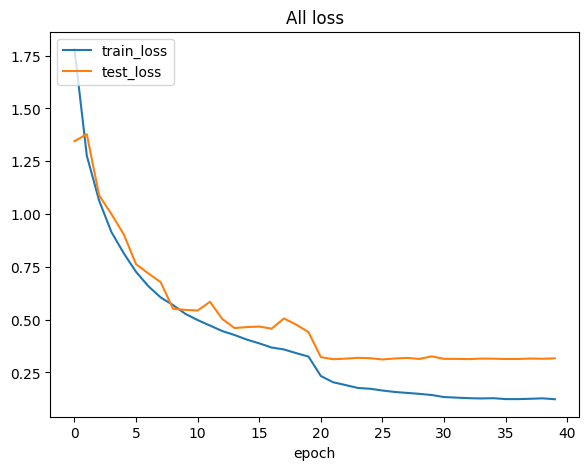

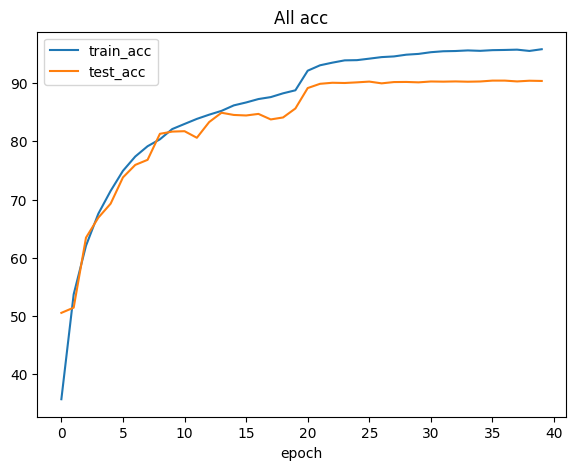

In [13]:
#繪製 Sparsity-Training 結果圖
import matplotlib.pyplot as plt
def plt_acc_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All acc')

    ax1.plot(train_accuracies)
    ax1.plot(test_accuracies)

    ax1.legend(['train_acc', 'test_acc'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()

def plt_loss_all():
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title('All loss')

    ax1.plot(train_losses)
    ax1.plot(test_losses)

    ax1.legend(['train_loss', 'test_loss'], loc='upper left')
    ax1.set_xlabel('epoch')
    plt.show()


plt_loss_all()
plt_acc_all()

## 繪製scaling factor 分布圖

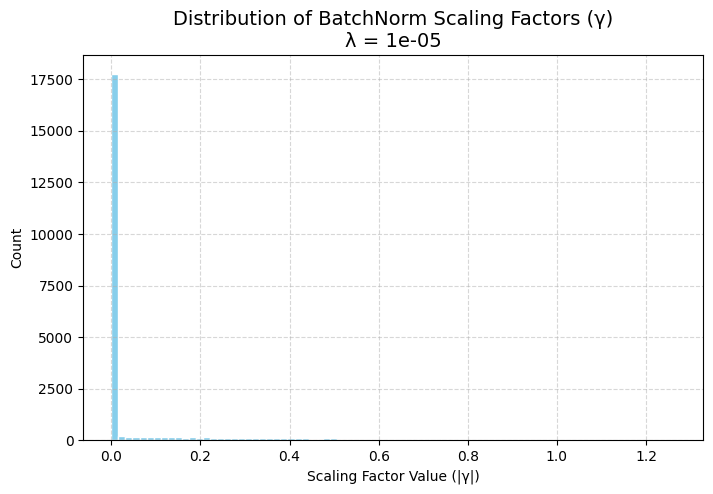

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_bn_distribution(model, lambd=0, bins=80, save_path=None):
    """繪製整個模型中所有 BatchNorm2d 層的 scaling factor (γ) 分布"""
    gammas = []

    # 收集所有 BatchNorm 的 weight (γ)
    for m in model.modules():
        if isinstance(m, torch.nn.BatchNorm2d):
            gammas.append(m.weight.data.abs().clone().cpu().numpy())

    # 合併成一個大的 array
    if len(gammas) == 0:
        print("No BatchNorm2d layers found.")
        return
    gammas = np.concatenate(gammas)

    # 繪製 histogram
    plt.figure(figsize=(8, 5))
    plt.hist(gammas, bins=bins, color='skyblue', edgecolor='white')
    plt.title(f"Distribution of BatchNorm Scaling Factors (γ)\nλ = {lambd}", fontsize=14)
    plt.xlabel("Scaling Factor Value (|γ|)")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.5)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# plot_bn_distribution(model, lambd=0)
plot_bn_distribution(model, lambd=1e-5)
# plot_bn_distribution(model, lambd=1e-4)